In [60]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from numba import njit
from tqdm import tqdm
plt.rcParams['figure.dpi'] = 150  # Set the figure dpi to 150 globally
plt.rcParams['font.family'] = 'serif' #Change font to Times New Roman
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [61]:
@njit
def lj_acc(rij, sigma=1.0):
    """
    Get the 2D Lennard-Jones acceleration of two masses separated by a distance rij.

    Parameters:
    -----------
    • rij : A numpy array of 2 elements storing the `x` and `y` values of the separation `rij`.
    • sigma: Lennard-Jones parameter sigma (default value is 1.0).

    Returns:
    --------
    The function returns one value:
    • a : A numpy array of 2 elements storing the `x` and `y` components of the acceleration.
    """
    rij = pbc_distance(rij, L)
    # Computing the magnitude of rij
    r = np.linalg.norm(rij)

    # Calculating the Lennard-Jones acceleration
    if r != 0: #takes care of  i not equal to j
        a = (48 / r**2) * (((sigma / r)**12) - (0.5 * (sigma / r)**6)) * (rij)
    else:
        a = np.array([0.0, 0.0])

    return a


@njit
def get_pe(step_pos, L):
    '''
    Get the 2D Lennard-Jones potential energy for a system of `N` masses.
    
    Parameters:
    -----------
    • step_pos : An `(N x 2)` numpy array of 2 elements storing the `x` and `y` values of each particle.
    • L : The size of the box.
    
    Returns:
    --------
    The function returns one value:
    • potential : The combined potential energy of the `N` masses.
    '''
    
    potential = 0

    N = step_pos.shape[0]

    for p in range(N - 1):
        for q in range(p + 1, N):
            rij = pbc_distance(step_pos[p] - step_pos[q], L)
            r = np.linalg.norm(rij)

            # Lennard-Jones potential parameters
            epsilon = 1.0  
            sigma = 1.0  

            potential += 4.0 * epsilon * ((sigma / r) ** 12 - (sigma / r) ** 6)

    return potential

@njit
def get_ke(step_vel):
    '''
    Get the kinetic energy for a system of `N` masses.
    
    Parameters:
    -----------
    • step_vel : An `(N x 2)` numpy array of 2 elements storing the `v_x` and `v_y` values of each particle.
    
    Returns:
    --------
    The function returns one value:
    • kinetic : The combined kinetic energy of the `N` masses.
    '''
    kinetic = 0
    kinetic += 0.5 * np.sum(step_vel**2) 
    
    return kinetic

@njit
def pbc_distance(rij, L):
    '''
    Get the correct distance between two particles, accounting for periodic boundary conditions.
    
    Parameters:
    -----------
    • rij : A numpy array of 2 elements storing the `x` and `y` values of the separation `rij`.
    • L : The size of the box.
    
    Returns:
    --------
    The function returns one value:
    • rij : The corrected r_ij, including the effects of periodic boundary conditions.
    '''
    
    for i in range(2):
        if np.abs(rij[i]) > 0.5 * L:
            rij[i] -= np.sign(rij[i]) * L
    
    return rij

@njit

def maxwell(v,T):
    '''
    Maxwell-Boltzmann distribution of velocities in two-dimensions
    
    Parameters:
    -----------
    • v    : Number or array of velocities
    • T    : Temperature at which the Maxwell-Boltzmann distribution is computed
    
    Returns:
    --------
    The function returns the probability density from the Maxwell-Boltzmann distribution:
    • p : If `v` is a numpy array, `p` is a numpy array. If `v` is a number, `p` is a number.
    '''

    p = (1./T)*v*np.exp(-0.5*v*v/T)
    
    return p

In [62]:
@njit
def init_pos(Lx, Ly, Nx, Ny):

    '''
    Assign the initial positions of the particles on a regular lattice
    
    Parameters:
    -----------
    • Lx   : x-length of the lattice
    • Ly   : y-length of the lattice
    • Nx   : An integer number of particles in the x-direction
    • Ny   : An integer number of particles in the y-direction
    
    Returns:
    --------
    The function returns one value:
    • ipos : A numpy array of (N x 2) elements storing the `x` and `y` coordinates of `N = Nx * Ny` particles.
    '''

    N = Nx*Ny                                       # Total number of particles in the lattice
    
    dx = Lx/Nx                                      # Spacing between particles along the  
    dy = Ly/Ny                                      # x and y axes
    
    ipos = np.zeros((N,2))                          # Empty array to store positions

    n=0                                             # Counter to count the number of particles
    
    for x in range(Nx):                             # Loop over all particles
        for y in range(Ny):
            ipos[n] = [dx/2 + dx*x, dy/2 + dy*y]    # Assign positions to each particle
            n+=1                                    # Increment counter
    
    return ipos


@njit
def init_vel(N):

    '''
    Assign the initial velocities of the particles
    
    Parameters:
    -----------
    • N    : An integer number of particles
    
    Returns:
    --------
    The function returns one value:
    • ivel : A numpy array of (N x 2) elements storing the `x` and `y` velocity components of `N` particles.
    '''
    
    ivel = np.zeros((N,2), dtype=np.float32)         # Initialise the empty array for velocities 

    T = 2.5                                          # Initial "temperature" of the system
    T0 = 1                                           # Temperature scale of the problem

    v0 = np.sqrt(2*T/T0)                             # Initial speed of each particle

    for i in range(N):                               # Loop over each particle and 
        r = 2*np.pi*np.random.random()               # assign it a random direction
        ivel[i][0] = v0 * np.cos(r)                  # Set the x and y components of the velocity
        ivel[i][1] = v0 * np.sin(r)                  # while keeping the magnitude constant

    vcm = np.sum(ivel,axis=0)/N                      # Compute the centre of mass velocity
    ivel = ivel-vcm                                  # Subtract the COM velocity so the COM is stationary

    return ivel

In [77]:
#@njit
def simulate(ipos, ivel, tf=100, dt=0.01, T=1.0, nu=0.1):
    n_steps = int(tf/dt)                                     # Number of simulation steps

    pos = np.zeros(shape=(n_steps, N, 2), dtype=np.float32) # Arrays to store the history of the particles' positions
    vel = np.zeros(shape=(n_steps, N, 2), dtype=np.float32) # and velocities

    KE = np.zeros(n_steps)                                 # Arrays to store the history of kinetic energies
    PE = np.zeros(n_steps)                                 # and potential energies

    pos[0] = ipos                                        # Setting initial positions to `ipos`
    vel[0] = ivel                                        # Setting initial velocities to `ivel`

    KE[0] = get_ke(vel[0])                               # Computing initial kinetic and potential energies
    PE[0] = get_pe(pos[0], L=L)

    for s in tqdm(range(1, n_steps)):                     # Loop over steps
        
        pos[s] = pos[s-1] + (dt/2) * vel[s-1]             # Increment positions to value at intermediate point

        for i in range(N):                              # Impose periodic boundary conditions
            for d in range(2):                          # for each dimension (x and y)
                if pos[s][i][d] > L:
                    pos[s][i][d] -= L
                elif pos[s][i][d] < 0:
                    pos[s][i][d] += L

        net_a = np.zeros((N, 2), dtype=np.float32)        # Empty array to store the net acceleration of each particle

        for p in range(N-1):                             # Computing the acceleration for each _pair_ of particles
            for q in range(p+1, N):
                acc = lj_acc(pos[s][p]-pos[s][q])            # Acceleration between pairs of particles
                net_a[p] += acc                              # Using the third-law to impart equal and opposite 
                net_a[q] -= acc                                          # accelerations to each particle

        vel[s] = vel[s-1] + dt * net_a                  # Update the velocity and final positions using the
        pos[s] = pos[s] + (dt/2) * vel[s]               # Velocity-Verlet scheme

        for i in range(N):                             # Reimpose periodic boundary conditions
            for d in range(2):
                if pos[s][i][d] > L:
                    pos[s][i][d] -= L
                elif pos[s][i][d] < 0:
                    pos[s][i][d] += L

        KE[s] = get_ke(vel[s])                           # Compute the kinetic and potential energies at
        PE[s] = get_pe(pos[s], L=L)                      # the current step

        for i in range(N):
            if np.random.rand() < nu * dt:               # Andersen Thermostat
                vel[s][i] = np.random.normal(scale=np.sqrt(T)) #the standard deviation is root kbT/m, we are ignoring kb and taking m=1

    return pos, vel, KE, PE

In [78]:
##############################################
########### SIMULATION PARAMETERS ############
##############################################


Nx = 5                                     # Number of particles per row initially along x
Ny = 5                                     # Number of particles per row iniailly along y
N = Nx*Ny                                  # Total number of particles
rho = 0.5                                  # Density of the system
L = np.sqrt(N/rho)                         # Length of the system

ipos = init_pos(Lx=L, Ly=L, Nx=Nx, Ny=Ny)  # Initial positions (square grid)
ivel = init_vel(N)                         # Initial velocities 


tf = 100
dt = 0.01
time = np.arange(0,int(tf/dt))*dt

In [79]:
%%time
##############################################
##### Run a single simulation forwards #######
##############################################

pos,vel, KE, PE = simulate(ipos, ivel, tf=tf, dt=dt)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1mUntyped global name 'get_ke':[0m [1m[1mCannot determine Numba type of <class 'function'>[0m
[1m
File "..\AppData\Local\Temp\ipykernel_29220\3086968328.py", line 14:[0m
[1m<source missing, REPL/exec in use?>[0m
[0m

In [67]:
print('Kinetic Energies of the particles are:', KE)
print('Potential Energies of the particles are:', PE)

Kinetic Energies of the particles are: [60.61499023 60.66868973 60.82995605 ... 19.24073982 19.42547417
 19.73552132]
Potential Energies of the particles are: [-25.78945517 -25.84318429 -26.00434482 ... -33.28624825 -33.4577825
 -33.75016571]


In [66]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plotting the initial configuration backwards
axs[0].scatter(ipos[:, 0], ipos[:, 1], color='firebrick', marker='o')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_title('Initial Configuration')

# Plotting the final configuration backwards
axs[1].scatter(pos[-1,:, 0], pos[-1,:, 1],color='firebrick', marker='o')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_title('Final Configuration')

plt.tight_layout()
plt.show()

In [68]:
%%time
##############################################
##### Run the same simulation backwards ######
##############################################

pos_reversed, vel_reversed, KE_reversed, PE_reversed = simulate(pos[-1], -vel[-1], tf=tf, dt=dt)

100%|██████████████████████████████████████████████████████████████████████████████| 9999/9999 [07:40<00:00, 21.73it/s]

CPU times: total: 2min 26s
Wall time: 7min 40s


In [69]:
print('Kinetic Energies of the particles are:', KE)
print('Potential Energies of the particles are:', PE)

Kinetic Energies of the particles are: [60.61499023 60.66868973 60.82995605 ... 19.24073982 19.42547417
 19.73552132]
Potential Energies of the particles are: [-25.78945517 -25.84318429 -26.00434482 ... -33.28624825 -33.4577825
 -33.75016571]


In [70]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plotting the initial configuration backwards
axs[0].scatter(pos[-1, :, 0], pos[-1, :, 1], color='firebrick', marker='o')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_title('Initial Configuration Backwards')

# Plotting the final configuration backwards
axs[1].scatter(pos_reversed[-1, :, 0], pos_reversed[-1, :, 1],color='firebrick', marker='o')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_title('Final Configuration Backwards')


plt.tight_layout()
plt.show()


In [57]:
def animate_particles(pos, save=True, save_name="D:\Semester 5\Statistical Mechanics\Assignments\Assignment 4\lennard_jones_Q3a.gif", save_dpi=300, save_fps=300):

    '''
    Animate a set of step-wise positions of `N` particles, with the option of saving a movie.
    
    Parameters:
    -----------
    • pos       : An array of `(n_steps x N x 2)` elements representing a snapshot of the system at each step.
    • save      : (Optional) Boolean to save the animation as a movie.
    • save_name : (Optional) Name of the output video.
    • save_dpi  : (Optional) DPI of the output movie.
    • save_fps  : (Optional) Frames-per-second of the output movie.
    
    Returns:
    --------
    This function returns an animation
    • ani       : A FuncAnimation object
    '''
    
    fig, ax = plt.subplots()      # Create an empty plot and fill it with the initial position of the particles
    plot, = ax.plot(pos[0,:,0], pos[0,:,1], ls='none',color='firebrick', marker='o', mec='darkred', ms=8)

    def plotsetup():              # Function to setup the plot canvas
        ax.set_aspect('equal')
        ax.set_xlim(0,L)
        ax.set_ylim(0,L)
        ax.set_title('2D system of particles')    
    
    def animate(frame):           # `Animate` function called by the FuncAnimation object below at each frame
        plot.set_data(pos[frame,:,0], pos[frame,:,1])

        return plot,
    
    steps = len(pos)              # Total steps
    
    ani = FuncAnimation(fig, animate, init_func=plotsetup(), frames=range(0,steps,int(1/dt)), interval=50, blit=True, repeat=True)

    if(save): # If `save==True`, a movie is created
        ani.save(save_name, dpi=save_dpi, fps=save_fps)
    
    return ani

In [58]:
%matplotlib tk  
# Matplotlib backend for animation
animate_particles(pos)

MovieWriter ffmpeg unavailable; using Pillow instead.


In [71]:
plt.plot(time, PE)
plt.title('Potential Energy')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.show()

plt.plot(time, KE)
plt.title('Kinetic Energy')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.show()

plt.plot(time, PE+KE)
plt.title('Total Energy')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.show()


plt.plot(time, PE, label='Potential Energy')
plt.plot(time, KE, label='Kinetic Energy')
plt.plot(time, PE+KE, label='Total Energy')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Energies')
plt.legend()
plt.show()

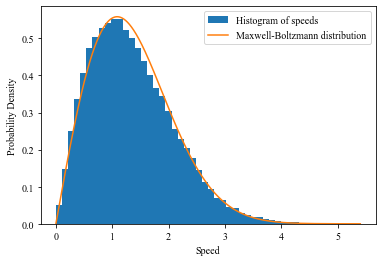

In [75]:
%matplotlib inline
# Calculating the speed (magnitude) for each particle in each sample
speeds = np.linalg.norm(vel, axis=2)

# Flattening the array to create a 1D array of speeds
speeds_flattened = speeds.flatten()

# Calculating temperature T using the average kinetic energy per particle
T = np.mean(KE) / (N)  

# Plotting the histogram of speeds and the theoretical Maxwell-Boltzmann distribution
plt.hist(speeds_flattened, bins=50, density=True, label='Histogram of speeds')
v_values = np.linspace(min(speeds_flattened), max(speeds_flattened), 1000)
plt.plot(v_values, maxwell(v_values, T), label='Maxwell-Boltzmann distribution')
plt.xlabel('Speed')
plt.ylabel('Probability Density')
plt.legend()
plt.show()